## Basic Implementation of PPO with a visual input layer

This is a thought experiment of what it would be like if I only had a visual feed of the environment (i.e. a camera), so I added a CNN input for the two Actor/Critic networks to see how well it could work.

The model learnt extremely slowly relatively to the previous one, but the training is stable and it consistently made gradual progress over 300 epochs and I have not committed the computing resource to take it as far as it can go. As far as I'm concerned, this does work.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from collections import namedtuple, deque
from itertools import count
from typing import List, Tuple, Dict, Optional, Callable
import copy # Needed for storing old policy network parameters
import gymnasium as gym
from celluloid import Camera
from IPython.display import HTML
from collections import deque
import os

# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import torchvision.transforms as transforms

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
seed = 77
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

Using device: cuda


In [2]:
# Visual input resolution
width = 84
height = 84

deque_k = 4  # number of frames to stack
frame_stack = deque(maxlen=deque_k)

# Define the Policy Network (Actor)
class CNNInput(nn.Module):
    """CNN visual input layer for the PPO"""
    def __init__(self, input_height, input_width):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3*deque_k, out_channels=16, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)

        # Compute flattened output size dynamically
        with torch.no_grad():
            input_dim = torch.zeros(1, 3*deque_k, input_height, input_width)
            x = self.forward_conv(input_dim)
            self.flat_dim = x.view(1, -1).size(1)  # flatten size for FC layers

    def forward_conv(self, x):
        x = F.relu(self.conv1(x))  # [B, 16, H/2, W/2]
        x = F.relu(self.conv2(x))  # [B, 32, H/4, W/4]
        x = F.relu(self.conv3(x))  # [B, 64, H/8, W/8]
        return x

    def forward(self, x):
        x = self.forward_conv(x)
        x = torch.flatten(x, start_dim=1)  # Flatten to [B, flat_dim]
        return x

# Define the Policy Network (Actor)
class PolicyNetwork(nn.Module):
    """ MLP Actor network for PPO """
    def __init__(self, input_height, input_width, n_actions):
        super().__init__()
        self.cnn = CNNInput(input_height, input_width)
        self.layer1 = nn.LazyLinear(128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x: torch.Tensor) -> Categorical:
        """
        Forward pass, returns a Categorical distribution.
        """
        #if not isinstance(x, torch.Tensor):
        #     x = torch.tensor(x, dtype=torch.float32, device=device)
        #elif x.dtype != torch.float32:
        #     x = x.to(dtype=torch.float32)
        #if x.dim() == 1:
        #    x = x.unsqueeze(0)

        x = self.cnn(x)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        action_logits = self.layer3(x)
        return Categorical(logits=action_logits)

# Define the Value Network (Critic)
class ValueNetwork(nn.Module):
    """ MLP Critic network for PPO """
    def __init__(self, input_height, input_width):
        super().__init__()
        self.cnn = CNNInput(input_height, input_width)

        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.cnn(x)  # visual features
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value

# Define the compute_gae function that's currently missing
def compute_gae(rewards: torch.Tensor, 
               values: torch.Tensor, 
               next_values: torch.Tensor, 
               dones: torch.Tensor, 
               gamma: float, 
               lambda_gae: float, 
               standardize: bool = True) -> torch.Tensor:
    """
    Computes Generalized Advantage Estimation (GAE).
    """
    advantages = torch.zeros_like(rewards)
    last_advantage = 0.0

    for t in reversed(range(len(rewards))):
        mask = 1.0 - dones[t]
        delta = rewards[t] + gamma * next_values[t] * mask - values[t]
        advantages[t] = delta + gamma * lambda_gae * last_advantage * mask
        last_advantage = advantages[t]

    if standardize:
        mean_adv = torch.mean(advantages)
        std_adv = torch.std(advantages) + 1e-8
        advantages = (advantages - mean_adv) / std_adv
        
    return advantages

def update_ppo(actor: PolicyNetwork,
               critic: ValueNetwork,
               actor_optimizer: optim.Optimizer,
               critic_optimizer: optim.Optimizer,
               states: torch.Tensor,
               actions: torch.Tensor,
               log_probs_old: torch.Tensor,
               advantages: torch.Tensor,
               returns_to_go: torch.Tensor,
               ppo_epochs: int,
               ppo_clip_epsilon: float,
               value_loss_coeff: float,
               entropy_coeff: float) -> Tuple[float, float, float]: # Return avg losses
    """
    Performs the PPO update for multiple epochs over the collected batch.

    Parameters:
    - actor, critic: The networks.
    - actor_optimizer, critic_optimizer: The optimizers.
    - states, actions, log_probs_old, advantages, returns_to_go: Batch data tensors.
    - ppo_epochs (int): Number of optimization epochs.
    - ppo_clip_epsilon (float): Clipping parameter epsilon.
    - value_loss_coeff (float): Coefficient for the value loss.
    - entropy_coeff (float): Coefficient for the entropy bonus.

    Returns:
    - Tuple[float, float, float]: Average policy loss, value loss, and entropy over the epochs.
    """
    total_policy_loss = 0.0
    total_value_loss = 0.0
    total_entropy = 0.0

    # Detach advantages and old log probs - they are treated as constants during the update
    advantages = advantages.detach()
    log_probs_old = log_probs_old.detach()
    returns_to_go = returns_to_go.detach()

    for _ in range(ppo_epochs):
        # --- Actor (Policy) Update --- 
        # Evaluate current policy
        policy_dist = actor(states)
        log_probs_new = policy_dist.log_prob(actions)
        entropy = policy_dist.entropy().mean() # Entropy for exploration bonus
        
        # Calculate ratio r_t(theta)
        ratio = torch.exp(log_probs_new - log_probs_old)
        
        # Calculate surrogate objectives
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1.0 - ppo_clip_epsilon, 1.0 + ppo_clip_epsilon) * advantages
        
        # PPO Clipped Policy Loss (negative because optimizer minimizes)
        # We add the entropy bonus (maximize entropy -> minimize negative entropy)
        policy_loss = -torch.min(surr1, surr2).mean() - entropy_coeff * entropy
        
        # Optimize the actor
        actor_optimizer.zero_grad()
        policy_loss.backward()
        actor_optimizer.step()
        
        # --- Critic (Value) Update --- 
        # Predict values
        values_pred = critic(states).squeeze()
        
        # Value loss (MSE)
        value_loss = F.mse_loss(values_pred, returns_to_go)
        
        # Optimize the critic
        critic_optimizer.zero_grad()
        # Scale value loss before backward pass
        (value_loss_coeff * value_loss).backward()
        critic_optimizer.step()
        
        # Accumulate losses for logging
        total_policy_loss += policy_loss.item() # Log negative clipped objective + entropy bonus
        total_value_loss += value_loss.item()
        total_entropy += entropy.item()
        
    # Calculate average losses over the epochs
    avg_policy_loss = total_policy_loss / ppo_epochs
    avg_value_loss = total_value_loss / ppo_epochs
    avg_entropy = total_entropy / ppo_epochs
    
    return avg_policy_loss, avg_value_loss, avg_entropy

# PPO loop
def collect_trajectories(env, actor, critic, batch_size):
    states, actions, rewards, dones = [], [], [], []
    log_probs, values, next_values = [], [], []
    episode_reward = 0
    obs, _ = env.reset()
    obs_image = get_visual_obs(env,frame_stack,reset=True).unsqueeze(0).to(device)  # [1, 3*deque_k, height, width]
    
    done = False
    steps = 0

    while steps < batch_size:
        state_tensor = torch.tensor(obs_image, dtype=torch.float32, device=device)
        with torch.no_grad():
            dist = actor(state_tensor)
            value = critic(state_tensor)

        action = dist.sample()
        log_prob = dist.log_prob(action)

        next_obs, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated
        episode_reward += reward

        states.append(obs_image.squeeze(0).cpu().numpy())
        actions.append(action.item())
        rewards.append(reward)
        dones.append(done)
        log_probs.append(log_prob.item())
        values.append(value.item())

        obs_image = get_visual_obs(env,frame_stack).unsqueeze(0).to(device)
        steps += 1

        if done:
            episode_rewards.append(episode_reward)
            obs, _ = env.reset()
            episode_reward = 0
            done = False

    # Bootstrap values
    for i in range(len(states)):
        s = torch.tensor(states[i], dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            next_v = critic(s).item()
        next_values.append(next_v)

    # Convert to tensors
    states = torch.tensor(states, dtype=torch.float32, device=device)
    actions = torch.tensor(actions, dtype=torch.int64, device=device)
    rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
    dones = torch.tensor(dones, dtype=torch.float32, device=device)
    log_probs_old = torch.tensor(log_probs, dtype=torch.float32, device=device)
    values = torch.tensor(values, dtype=torch.float32, device=device)
    next_values = torch.tensor(next_values, dtype=torch.float32, device=device)

    # Compute advantages and returns
    advantages = compute_gae(rewards, values, next_values, dones, gamma, lambda_gae)
    returns_to_go = advantages + values

    return states, actions, log_probs_old, advantages, returns_to_go

# Resize, convert to tensor, and normalize
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((height, width)),   # Input resolution
    transforms.ToTensor(),         # Converts to [0, 1]
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

def get_visual_obs(env, frame_stack, k=deque_k, reset=False):
    """
    Returns a stacked tensor of the last k frames.
    
    Args:
        env: The environment to render from.
        k (int): Number of frames to stack.
        reset (bool): If True, initializes the buffer with the first frame cloned k times.
    
    Returns:
        torch.Tensor: Stacked [3*k, H, W] tensor.
    """
    frame = env.render()
    frame = preprocess(frame)  # shape: [3, H, W]

    if reset or frame_stack is None or len(frame_stack) < k:
        # Initialize frame_stack with k clones of the first frame
        frame_stack = deque([frame.clone() for _ in range(k)], maxlen=k)
    else:
        # Push the latest frame
        frame_stack.append(frame)

    # Stack along the channel dimension: shape [3*k, H, W]
    stacked_frames = torch.cat(list(frame_stack), dim=0)
    return stacked_frames

In [3]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
n_actions = env.action_space.n

# Initialize policy and value networks
actor = PolicyNetwork(height, width, n_actions).to(device)
critic = ValueNetwork(height, width,).to(device)

# Initialize optimizers
actor_optimizer = optim.Adam(actor.parameters(), lr=2.5e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

# Hyperparameters
gamma = 0.99
lambda_gae = 0.95
ppo_clip_epsilon = 0.2
value_loss_coeff = 0.5
entropy_coeff = 0.01
ppo_epochs = 4
batch_size = 2048
total_updates = 300

episode_rewards = []

In [4]:
# Logging variables
log = {}
for item in ["update", "rewards","policy_loss","value_loss","entropy"]:
    log[item] = []

# Main training loop
for update in range(1, total_updates + 1):
    states, actions, log_probs_old, advantages, returns_to_go = collect_trajectories(
        env, actor, critic, batch_size
    )

    policy_loss, value_loss, entropy = update_ppo(
        actor, critic, actor_optimizer, critic_optimizer,
        states, actions, log_probs_old, advantages, returns_to_go,
        ppo_epochs, ppo_clip_epsilon, value_loss_coeff, entropy_coeff
    )

    avg_reward = np.mean(episode_rewards)
    
    log["update"].append(update)
    log["rewards"].append(avg_reward)
    log["policy_loss"].append(policy_loss)
    log["value_loss"].append(value_loss)
    log["entropy"].append(entropy)
    print(f"Update {update:03d} | Reward: {avg_reward:.2f} | Policy Loss: {policy_loss:.3f} | Value Loss: {value_loss:.3f} | Entropy: {entropy:.3f}")

C:\Users\wtan0\AppData\Local\Temp\ipykernel_8524\3491711011.py:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(obs_image, dtype=torch.float32, device=device)
C:\Users\wtan0\AppData\Local\Temp\ipykernel_8524\3491711011.py:241: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  states = torch.tensor(states, dtype=torch.float32, device=device)


Update 001 | Reward: 20.67 | Policy Loss: -0.009 | Value Loss: 0.998 | Entropy: 0.691
Update 002 | Reward: 20.45 | Policy Loss: -0.009 | Value Loss: 0.995 | Entropy: 0.686
Update 003 | Reward: 21.07 | Policy Loss: -0.008 | Value Loss: 0.977 | Entropy: 0.692
Update 004 | Reward: 21.18 | Policy Loss: -0.007 | Value Loss: 0.980 | Entropy: 0.693
Update 005 | Reward: 21.30 | Policy Loss: -0.007 | Value Loss: 0.975 | Entropy: 0.693
Update 006 | Reward: 21.51 | Policy Loss: -0.007 | Value Loss: 0.981 | Entropy: 0.693
Update 007 | Reward: 21.70 | Policy Loss: -0.007 | Value Loss: 1.206 | Entropy: 0.693
Update 008 | Reward: 21.94 | Policy Loss: -0.007 | Value Loss: 0.994 | Entropy: 0.693
Update 009 | Reward: 21.87 | Policy Loss: -0.007 | Value Loss: 0.976 | Entropy: 0.693
Update 010 | Reward: 22.18 | Policy Loss: -0.007 | Value Loss: 0.990 | Entropy: 0.693
Update 011 | Reward: 22.25 | Policy Loss: -0.007 | Value Loss: 0.992 | Entropy: 0.693
Update 012 | Reward: 22.15 | Policy Loss: -0.007 | Val

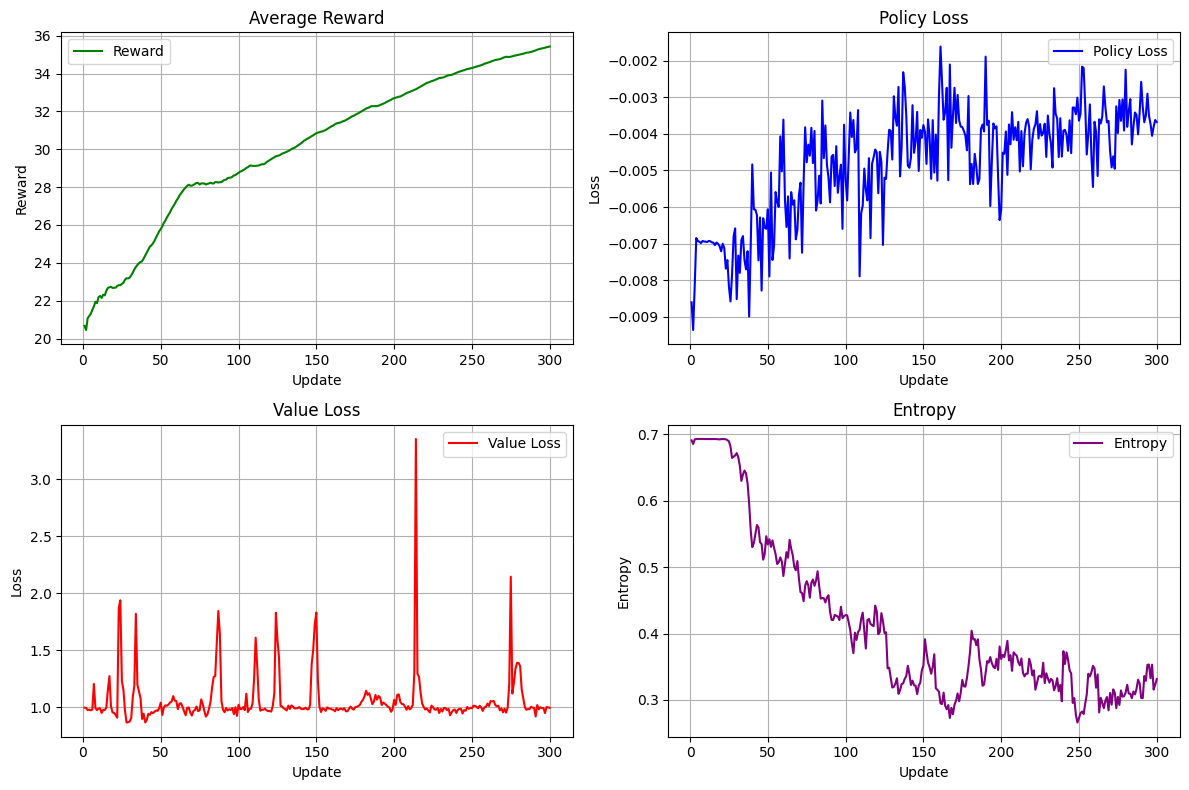

In [5]:
def plot_training_metrics(updates, rewards, policy_losses, value_losses, entropies):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Reward plot
    axs[0, 0].plot(updates, rewards, label="Reward", color="green")
    axs[0, 0].set_title("Average Reward")
    axs[0, 0].set_xlabel("Update")
    axs[0, 0].set_ylabel("Reward")

    # Policy loss plot
    axs[0, 1].plot(updates, policy_losses, label="Policy Loss", color="blue")
    axs[0, 1].set_title("Policy Loss")
    axs[0, 1].set_xlabel("Update")
    axs[0, 1].set_ylabel("Loss")

    # Value loss plot
    axs[1, 0].plot(updates, value_losses, label="Value Loss", color="red")
    axs[1, 0].set_title("Value Loss")
    axs[1, 0].set_xlabel("Update")
    axs[1, 0].set_ylabel("Loss")

    # Entropy plot
    axs[1, 1].plot(updates, entropies, label="Entropy", color="purple")
    axs[1, 1].set_title("Entropy")
    axs[1, 1].set_xlabel("Update")
    axs[1, 1].set_ylabel("Entropy")

    for ax in axs.flat:
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_training_metrics(log["update"],log["rewards"],log["policy_loss"],log["value_loss"],log["entropy"])

In [7]:
# Visual showcase of how the PPO agent has learnt to solve the cartpole problem

obs, _ = env.reset()
obs_image = get_visual_obs(env,frame_stack,reset=True).unsqueeze(0).to(device)
frames = []

# Collect frames
for _ in range(100):
    frame = env.render()
    frames.append(frame)
    obs_image = get_visual_obs(env,obs_image).unsqueeze(0).to(device)
    obs_tensor = torch.tensor(obs_image, dtype=torch.float32, device=device)
    with torch.no_grad():
        action = actor(obs_tensor).sample().item()
    obs, _, terminated, truncated, _ = env.step(action)

env.close()

C:\Users\wtan0\AppData\Local\Temp\ipykernel_8524\1996417107.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_tensor = torch.tensor(obs_image, dtype=torch.float32, device=device)
C:\Users\wtan0\anaconda3\envs\pb\lib\site-packages\gymnasium\envs\classic_control\cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


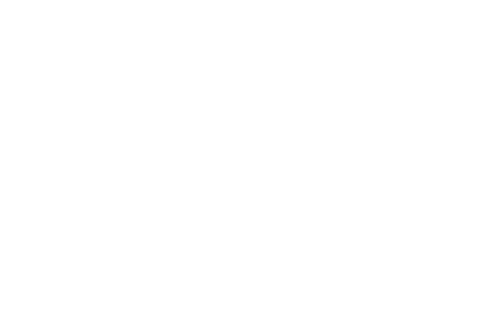

In [8]:
# Plot and animate with Celluloid
fig = plt.figure(figsize=(6, 4))
camera = Camera(fig)

for frame in frames:
    plt.imshow(frame)
    plt.axis("off")
    camera.snap()

# Create animation
animation = camera.animate(interval=10)

# Display animation directly
HTML(animation.to_jshtml())